# Transformer for Source Code

## Load Vocab from File

In [1]:
import torch
from models.trav_trans.dataset import Vocab

vocab = Vocab("output/vocab.pkl")

INFO:root:Loaded vocab from: output/vocab.pkl
INFO:root:Vocab size: 100002


## Load Model from File

In [4]:
import model
model = model.from_file("output/model-8.pt", vocab)
m = model.eval()

## Plot Loss

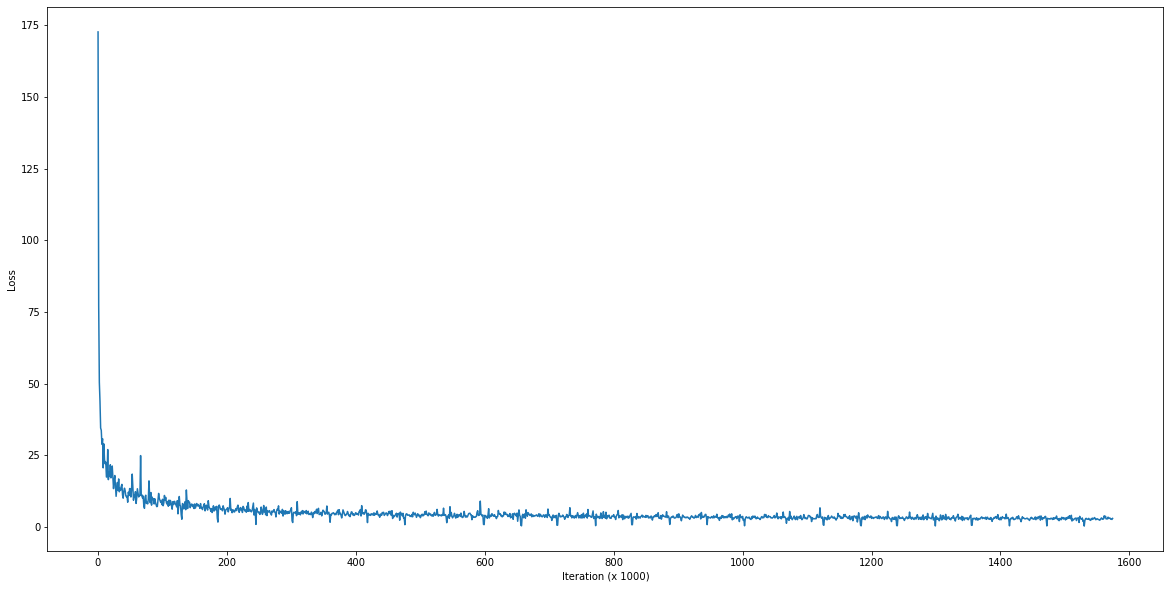

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle

with open("output/losses.pickle", "rb") as fin:
    losses = pickle.load(fin)
l = [loss[2] for loss in losses]
figure(figsize=(20, 10))
plt.xlabel("Iteration (x 1000)")
plt.ylabel("Loss")
plt.plot(range(len(losses)), l)

In [4]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
# count_parameters(model)

## Generate Tokens

In [5]:
from ipywidgets import interact, widgets
from IPython.display import display

textarea = widgets.Textarea(
    value="a = [1, 2, 3, 4, 5]\nprint(len(a))",
    placeholder='Type something',
    description='Python Code',
    disabled=False,
    layout=widgets.Layout(width="100%", height="300px")
)
display(textarea)

Textarea(value='a = [1, 2, 3, 4, 5]\nprint(len(a))', description='Python Code', layout=Layout(height='300px', …

In [50]:
import code_parser, generate_new_trees, json, utils
ast_raw = code_parser.parse_code(textarea.value)
ast = json.dumps(generate_new_trees.convert(json.loads(ast_raw)))
ast_original = ast
# Remove last 2 nodes
ast = json.dumps(json.loads(ast)[:-2])

Complete tree


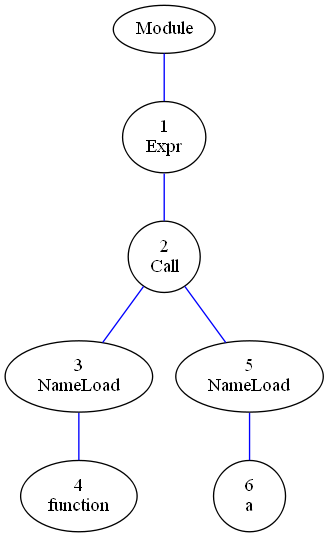

In [51]:
from IPython.display import Image
import generate_graph

print("Complete tree")
outfile = "outfile_original.png"
generate_graph.visualize(ast_original, outfile)
Image(outfile)

Remove last two nodes


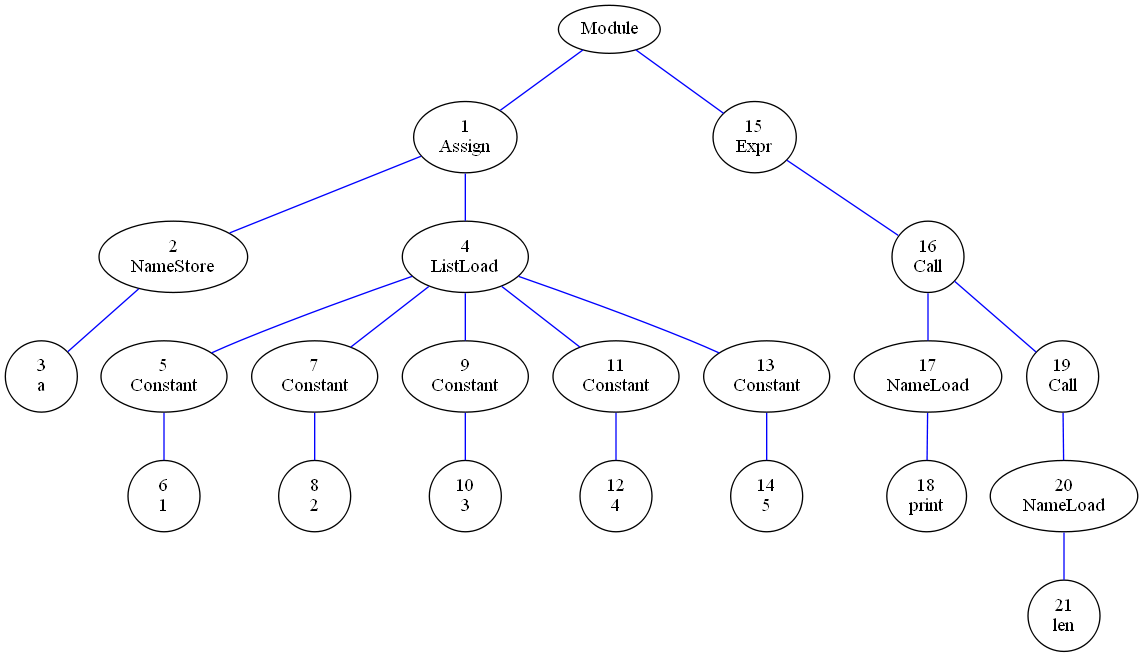

In [8]:
print("Remove last two nodes")
outfile = "outfile.png"
generate_graph.visualize(ast, outfile)
Image(outfile)

In [9]:
import torch.nn.functional as F

def generate_greedy(idx, iterations):
    input = idx
    for i in range(iterations):
        with torch.no_grad():
            output = model(torch.tensor(input), None)
        logits = output[-1]
        softmax = F.softmax(logits, dim=-1)
        top_k_values, top_k_indices = torch.topk(softmax, 5)
        for e, v in enumerate(top_k_values):
            print("Prediction {}: {}({})".format(i, vocab.idx2vocab[top_k_indices[e]], round(float(v), 2)))
        input.append(top_k_indices[0].item())
    return input

In [10]:
import numpy as np

def generate_beams(model, context, num_beams=2, depth=2):
    beam_heads = [{"context": context, "prob": []}] * num_beams
    
    for d in range(depth):
        for b in range(num_beams):
            temp_context = beam_heads[b]["context"].copy()
            with torch.no_grad():
                top_k_values, top_k_indices = torch.topk(F.softmax(model(torch.tensor(temp_context), None)[-1], dim=-1), num_beams)
            new_context = beam_heads[b]["context"].copy()
            new_context.append(top_k_indices[b].item())
            new_probability = beam_heads[b]["prob"].copy()
            new_probability.append(top_k_values[b].item())
            beam_heads[b] = {"context": new_context, "prob": new_probability}
    top_beam_id = 0
    for b in range(num_beams):
        if np.prod(beam_heads[b]["prob"]) > np.prod(beam_heads[top_beam_id]["prob"]):
            top_beam_id = b
    return [vocab.idx2vocab[i] for i in beam_heads[top_beam_id]["context"]]

In [6]:
def generate_test(model, context, depth=2, top_k=10):
    model.eval()
    with torch.no_grad():
        output = model(torch.tensor(context), None)[-1]
        top_k_values, top_k_indices = torch.topk(output, top_k)
        return top_k_values, top_k_indices

In [12]:
num_gen = 2

nodes = utils.get_dfs(json.loads(ast))
nodes_original = utils.get_dfs(json.loads(ast_original))
idx = vocab.convert([nodes, 0])[0]
idx_original = vocab.convert([nodes_original, 0])[0]
print("Original: ")
print(" ".join([vocab.idx2vocab[n] for n in idx_original]))
print("-" * 20)
print("Prediction: ")
print(" ".join(generate_beams(model, idx, num_beams=4, depth=2)))


Original: 
Module Assign NameStore a ListLoad Constant 1 Constant 2 Constant 3 Constant 4 Constant 5 Expr Call NameLoad print Call NameLoad len NameLoad a
--------------------
Prediction: 
Module Assign NameStore a ListLoad Constant 1 Constant 2 Constant 3 Constant 4 Constant 5 Expr Call NameLoad print Call NameLoad len NameLoad Constant


In [2]:
import models.trav_trans.dataset as dataset
setup = dataset.Setup("output", "output/dps.txt", "output/ids.txt")

INFO:root:Writing metrics to: output\train_metrics.txt
INFO:root:Loaded vocab from: output\vocab.pkl
INFO:root:Vocab size: 100002
INFO:root:Loaded dataset from output\train_converted.txt


In [14]:
import torch
dataloader = torch.utils.data.DataLoader(
    setup.dataset,
    batch_size=1,
    collate_fn=lambda b: dataset.Dataset.collate(b, vocab.pad_idx)
)
vocab = setup.vocab
batch = next(iter(dataloader))

x = batch["input_seq"][0]
y = batch["target_seq"][0]
ids = batch["ids"]["leaf_ids"]

predict_id = 4

y_type = x[ids[predict_id]].item()
y_value = y[ids[predict_id]].item()

model.eval()
with torch.no_grad():
    output = model(x[range(ids[predict_id])], None)
    # Predict next 2 instead of 1
    type_prediction = generate_test(model, [i.item() for i in x[range(ids[predict_id])]])
    value_prediction = generate_test(model, [i.item() for i in x[range(ids[predict_id] + 1)]])
    print("=" * 20)
    # Check if type in prediction
    print("Type Prediction:\nExpected Token: \n\t{}\nPredicted Token: \n\t{}".format(vocab.idx2vocab[y_type], "\n\t".join([vocab.idx2vocab[p.item()] for p in type_prediction[1]])))
    if y_type in type_prediction[1]:
        print("Reciprocal Rank for Type: {}".format(1 / ((type_prediction[1] == y_type).nonzero(as_tuple=True)[0].item() + 1)))
    else:
        print("Reciprocal Rank for Type: 0")
    print()
    # Check if value in prediction
    print("Value Prediction:\nExpected Token: \n\t{}\nPredicted Token: \n\t{}".format(vocab.idx2vocab[y_value], "\n\t".join([vocab.idx2vocab[p.item()] for p in value_prediction[1]])))
    if y_value in value_prediction[1]:
        print("Reciprocal Rank for Value: {}".format(1 / ((value_prediction[1] == y_value).nonzero(as_tuple=True)[0].item() + 1)))
    else:
        print("Reciprocal Rank for Value: 0")
    #print("Next 2 node predictions for {}: \n\t{}\nTarget:\n\t{}".format(ids[predict_id], [vocab.idx2vocab[p] for p in prediction], [vocab.idx2vocab[t] for t in to_predict]))

Type Prediction:
Expected Token: 
	alias
Predicted Token: 
	alias
	ImportFrom
	ClassDef
	Import
	identifier
	Assign
	FunctionDef
	Expr
	TryExcept
	Raise
Reciprocal Rank for Type: 1.0

Value Prediction:
Expected Token: 
	<unk_token>
Predicted Token: 
	<unk_token>
	*
	base
	context
	TestCase
	None
	open
	params
	count
	utils
Reciprocal Rank for Value: 1.0
